In [1]:
import os
from math import pi

# Use 8 CPU devices
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random

# jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [3]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 200, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                        #   double_map = True,
                          # batch_size = 25_000, 
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (5000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=200*u.kpc.to(code_units.code_length)


#sampling the center of mass on the sphere
key = random.PRNGKey(45)
num_samples = 1                                             # Number of positions to generate, we only care about the center of mass
pos_com = sample_position_on_circle(key, rp, num_samples)   # Sample the position of the center of mass on a circle of radius rp
inclination = jnp.radians(30)                               # 30-degree inclination of the orbit
pos_com = inclined_position(pos_com, inclination)           # Rotate the center of mass position by the inclination angle
vel_com = jnp.zeros_like(pos_com)                           # Initialize velocities to zero, it dosen't matter because the acceleration depend only on the postion
state_com = construct_initial_state(pos_com, vel_com)

# Calculate the acceleration at the center of mass, because v_c = sqrt(rp*a) in circular motion
acc_com = MyamotoNagai(state_com, config, params, return_potential=False) + NFW(state_com, config, params, return_potential=False)
#modulus of the circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
#bulk motion to give to each particle of the Plummer sphere
vel_com = inclined_circular_velocity(pos_com, v_c, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)




In [4]:
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import shard_map
from jax.sharding import NamedSharding

# Create a mesh from all devices
devices = jax.devices()
mesh = Mesh(devices, axis_names=('N_particles',))
sharding = NamedSharding(mesh, P('N_particles')) 

In [5]:
#let's shard position, velocity and mass
shard_inital_state = jax.device_put(initial_state, sharding)
print(shard_inital_state.shape)
print(shard_inital_state.devices())

shard_mass = jax.device_put(mass, sharding)
print(shard_mass.shape)
print(shard_mass.devices())

del initial_state
del mass
del velocities
del positions

(10000, 2, 3)
{CudaDevice(id=2), CudaDevice(id=1), CudaDevice(id=0), CudaDevice(id=3)}
(10000,)
{CudaDevice(id=2), CudaDevice(id=1), CudaDevice(id=0), CudaDevice(id=3)}


In [6]:
#lets's try to integrate now
snapshots = jax.block_until_ready(time_integration(shard_inital_state, shard_mass, config, params))

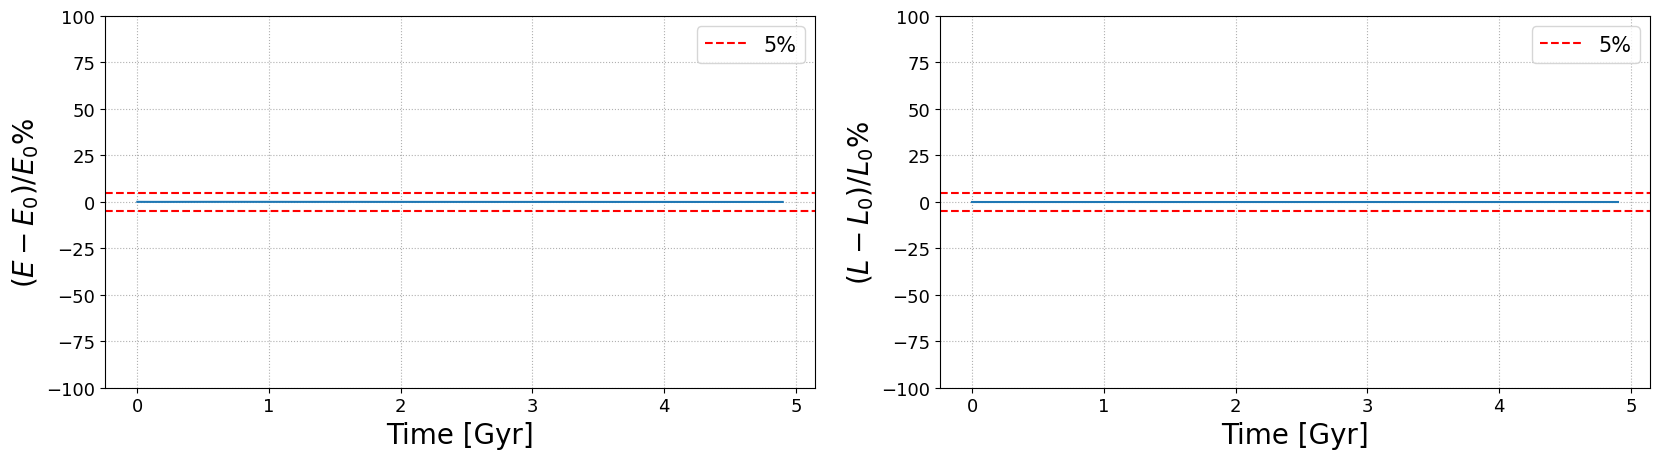

In [7]:
energy_angular_momentum_plot(snapshots, code_units,)

# Energy and Angular momentum  coordinate 

Total energy of the particles:  (10000,)
Total angular momentum of the particles:  (10000, 3)


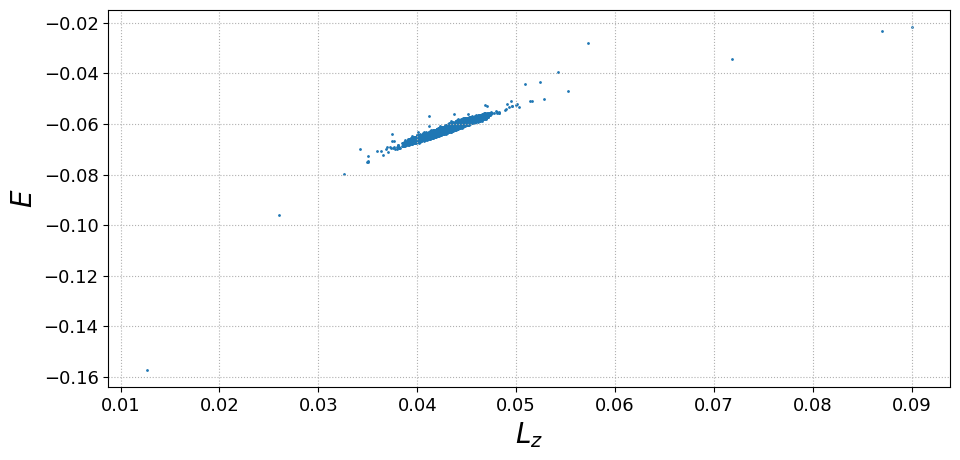

In [8]:
from odisseo.utils import E_tot, Angular_momentum

final_snapshot = snapshots.states[-1]

particles_energy = E_tot(state=final_snapshot, mass=shard_mass, config=config, params=params)
particles_angular_momentum = Angular_momentum(state=final_snapshot, mass=shard_mass)

print("Total energy of the particles: ", particles_energy.shape)
print("Total angular momentum of the particles: ", particles_angular_momentum.shape)

fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(111)
ax.scatter(particles_angular_momentum[:, 2], particles_energy, s=1)
ax.set_xlabel("$L_z$")
ax.set_ylabel("$E$")
ax.grid(linestyle='dotted')

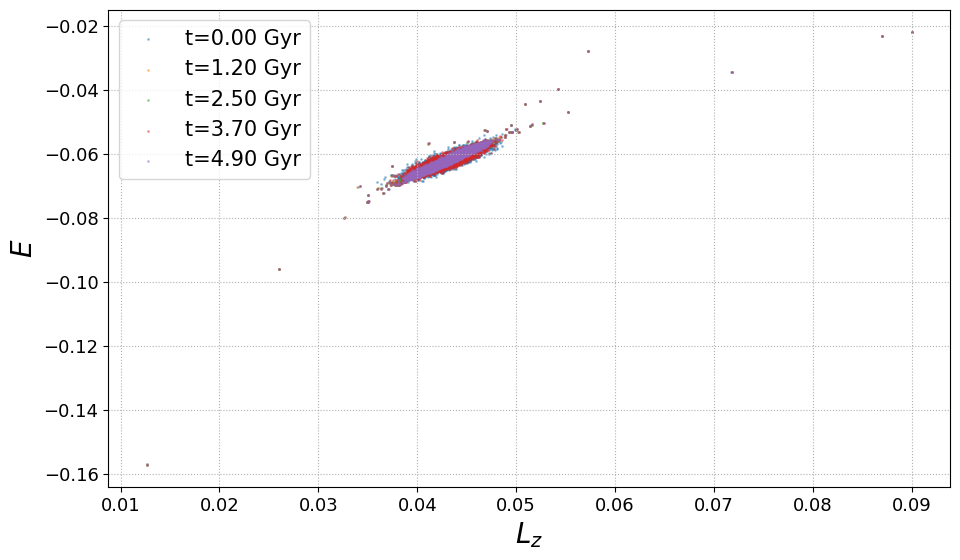

In [9]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
ax = fig.add_subplot(111)
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    state = snapshots.states[i]
    particles_energy = E_tot(state=state, mass=shard_mass, config=config, params=params)
    particles_angular_momentum = Angular_momentum(state=state, mass=shard_mass)
    ax.scatter(particles_angular_momentum[:, 2], particles_energy, s=1, alpha=0.4,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
    ax.set_xlabel("$L_z$")
    ax.set_ylabel("$E$")
    # ax.set_xlim(0.04, 0.08)
    # ax.set_ylim(-0.06, 0.0)
    ax.legend()
    ax.grid(linestyle='dotted')
    

# Elliptical orbit 

In [10]:
from jax.scipy.integrate import trapezoid
from galpy.potential import MiyamotoNagaiPotential


def mass_enclosed_MN(R, z):
    """
    Compute the mass of the Myamoto-Nagai potential at a given radius R.

    """
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)
    M = params.MN_params.M * code_units.code_mass.to( u.Msun)

    # Compute the mass using the Myamoto-Nagai formula
    mp = MiyamotoNagaiPotential(amp = M, a=a, b=b,) 

    return mp.mass(R, z) * u.Msun.to(code_units.code_mass)
    
@jit
def mass_enclosed_NFW(R):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))

    

In [11]:
params.t_end

3.353543704601728

In [12]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 500, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                        #   double_map = True,
                          # batch_size = 25_000, 
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
ra = 200*u.kpc.to(code_units.code_length)
e = 0.9
rp = (1-e)/(1+e) * ra

pos_com = sample_position_on_sphere(key=key,
                                r_p = rp,
                                num_samples=1,)
z = pos_com[0, 2]
inclination = jnp.pi/2 - jnp.acos(z/rp)

mass1 = mass_enclosed_MN(rp, z) + mass_enclosed_NFW(rp)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel_com = inclined_circular_velocity(pos_com, bulk_velocity_modulus, inclination)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [13]:
#lets's try to integrate now
snapshots = jax.block_until_ready(time_integration(initial_state, shard_mass, config, params))

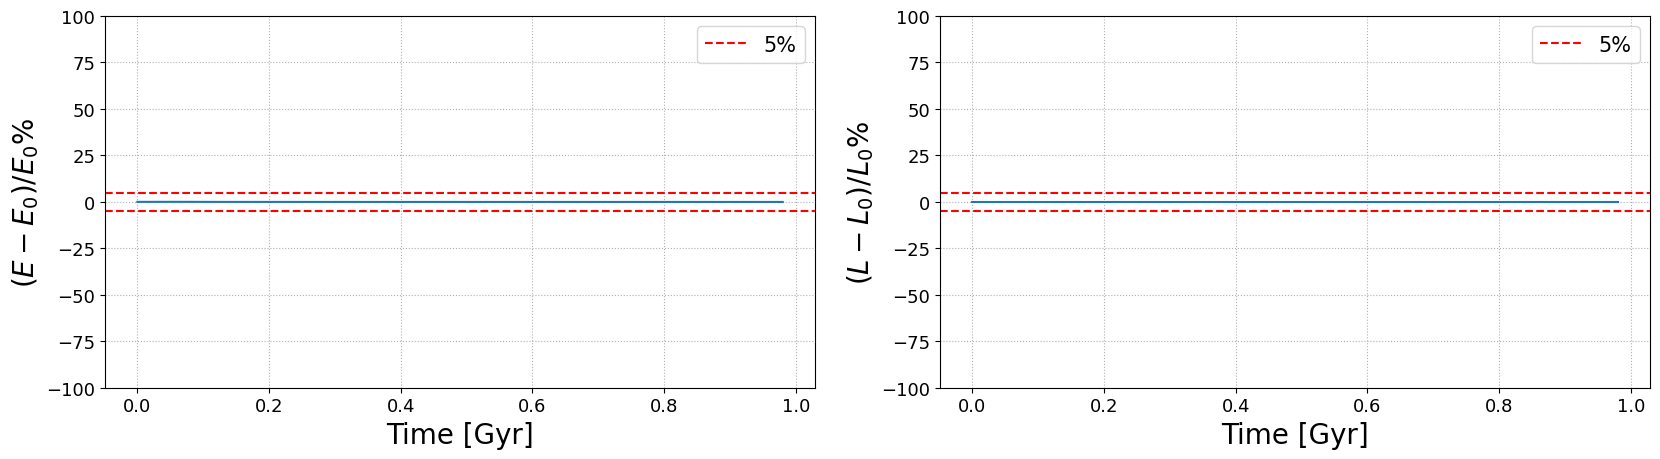

In [14]:
energy_angular_momentum_plot(snapshots, code_units,)

Total energy of the particles:  (10000,)
Total angular momentum of the particles:  (10000, 3)


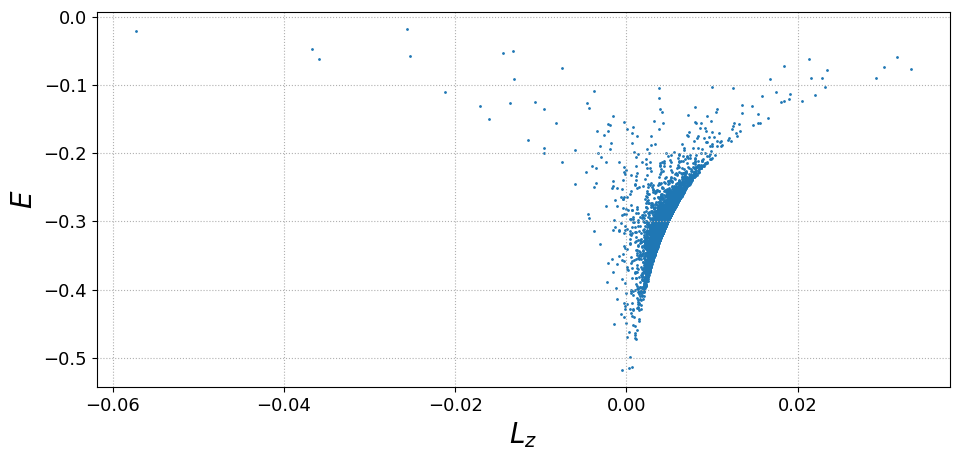

In [15]:
from odisseo.utils import E_tot, Angular_momentum

final_snapshot = snapshots.states[-1]

particles_energy = E_tot(state=final_snapshot, mass=shard_mass, config=config, params=params)
particles_angular_momentum = Angular_momentum(state=final_snapshot, mass=shard_mass)

print("Total energy of the particles: ", particles_energy.shape)
print("Total angular momentum of the particles: ", particles_angular_momentum.shape)

fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(111)
ax.scatter(particles_angular_momentum[:, 2], particles_energy, s=1)
ax.set_xlabel("$L_z$")
ax.set_ylabel("$E$")
ax.grid(linestyle='dotted')

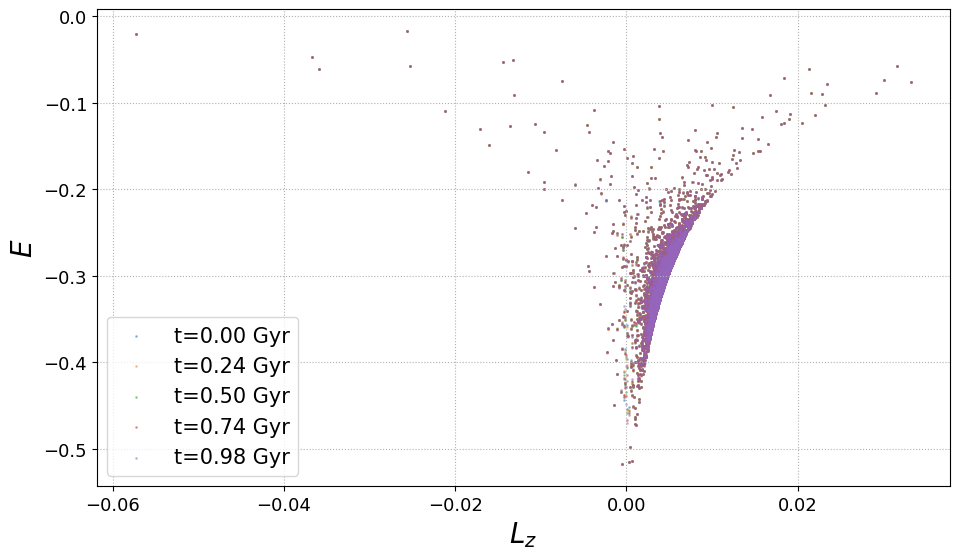

In [16]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
ax = fig.add_subplot(111)
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    state = snapshots.states[i]
    particles_energy = E_tot(state=state, mass=shard_mass, config=config, params=params)
    particles_angular_momentum = Angular_momentum(state=state, mass=shard_mass)
    ax.scatter(particles_angular_momentum[:, 2], particles_energy, s=1, alpha=0.4,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
    ax.set_xlabel("$L_z$")
    ax.set_ylabel("$E$")
    
    # ax.set_xlim(0.04, 0.08)
    # ax.set_ylim(-0.06, 0.0)
    ax.legend()
    ax.grid(linestyle='dotted')
    

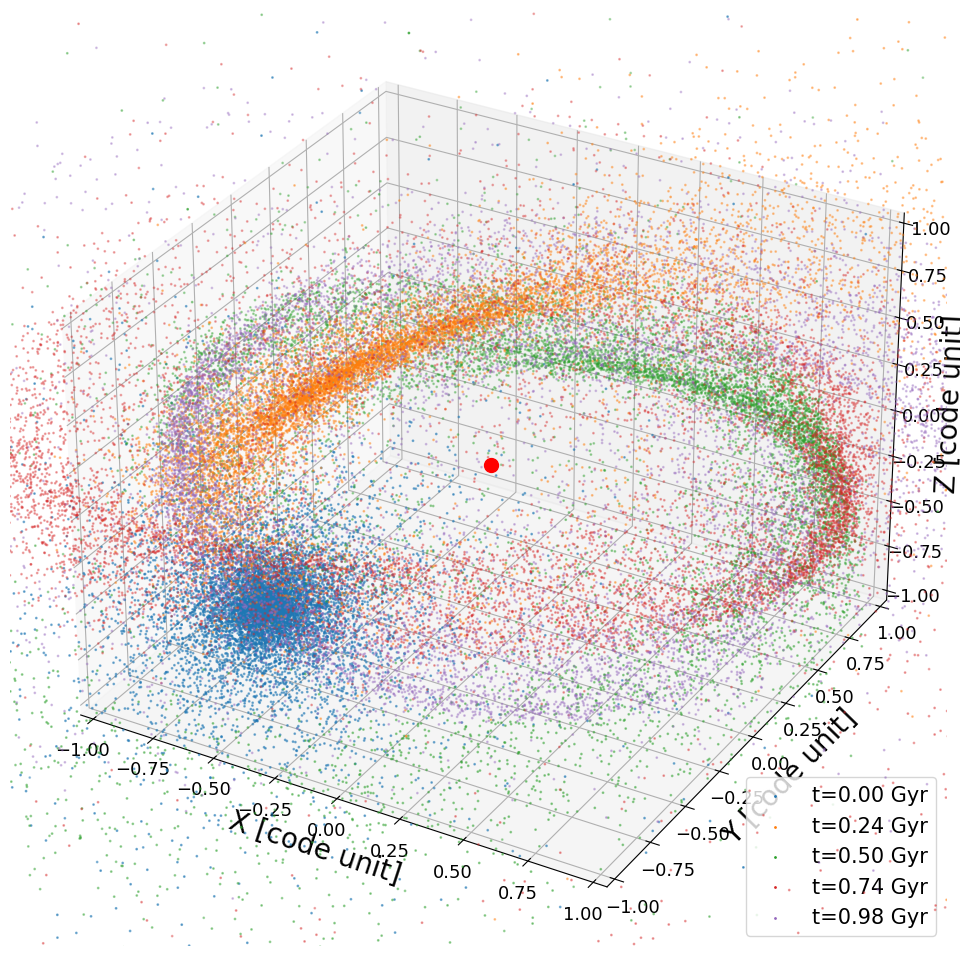

In [17]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2], s=1,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.set_xlim(-rp, rp)
ax.set_ylim(-rp, rp)
ax.set_zlim(-rp, rp)
ax.legend()

# Galpy Milky Way satellite

(-100.0, 100.0)

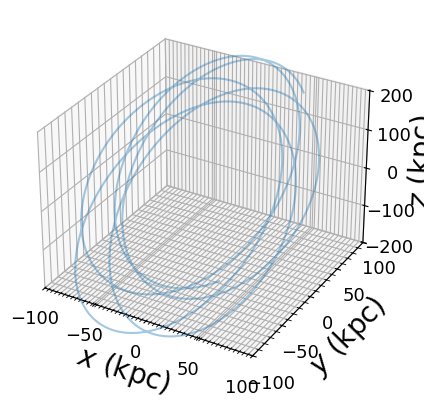

In [18]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import numpy 


o = Orbit.from_name('MW satellite galaxies')
fornax = o[o.name == 'Fornax']

ts= numpy.linspace(0.,1000.,190001)
fornax.integrate(ts,MWPotential2014)
fornax.plot3d(alpha=0.4)
plt.xlim(-100.,100.)
plt.ylim(-100.,100)


# Evolution backward in time

In [19]:
final_snapshot = snapshots.states[-1]

dt = jnp.array(-0.01)
backward_in_time = odisseo.integrators.leapfrog(final_snapshot, mass, dt, config=config, params=params)

In [20]:
# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 500, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.kpc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = -(1000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 
                        

#lets's try to integrate backward, we need to reverse the velocity 
final_snapshot_negative_time = final_snapshot.copy()
backward_snapshots = jax.block_until_ready(time_integration(final_snapshot_negative_time, shard_mass, config, params))

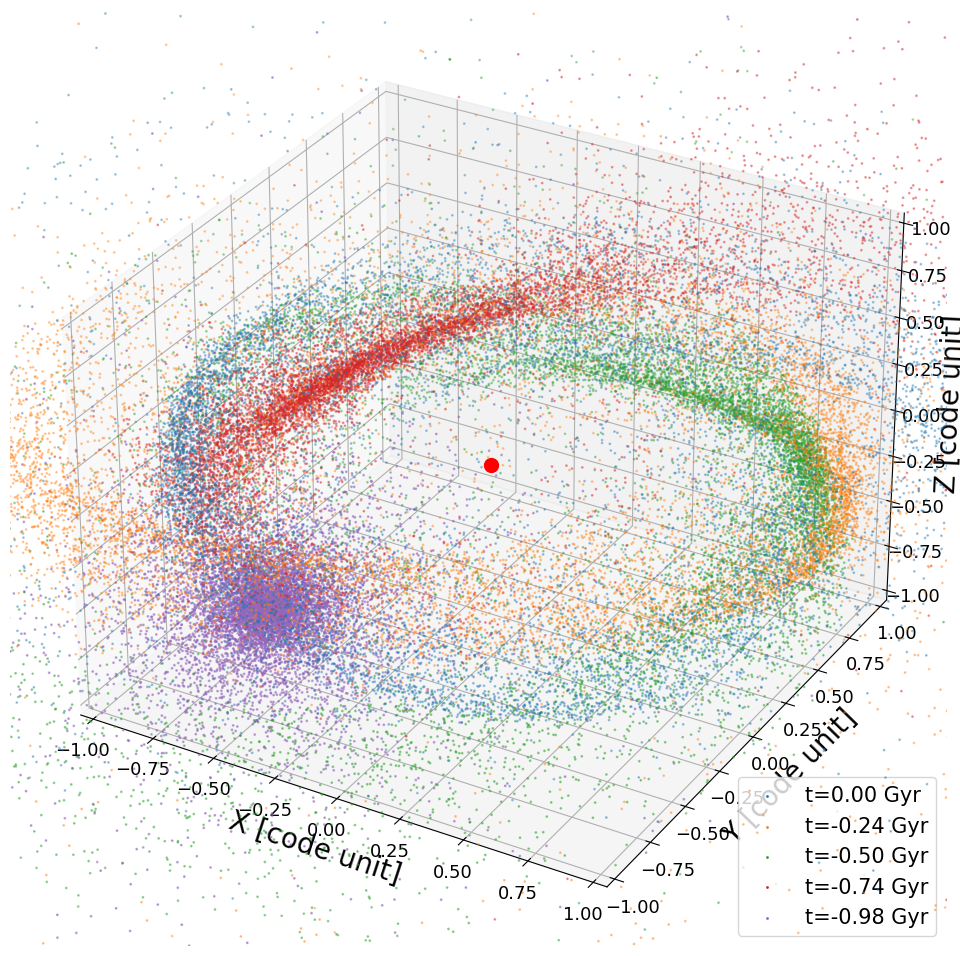

In [21]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(backward_snapshots.states[i, :, 0, 0], backward_snapshots.states[i, :, 0, 1], backward_snapshots.states[i, :, 0, 2], s=1,label=f"t={(backward_snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.set_xlim(-rp, rp)
ax.set_ylim(-rp, rp)
ax.set_zlim(-rp, rp)
ax.legend()

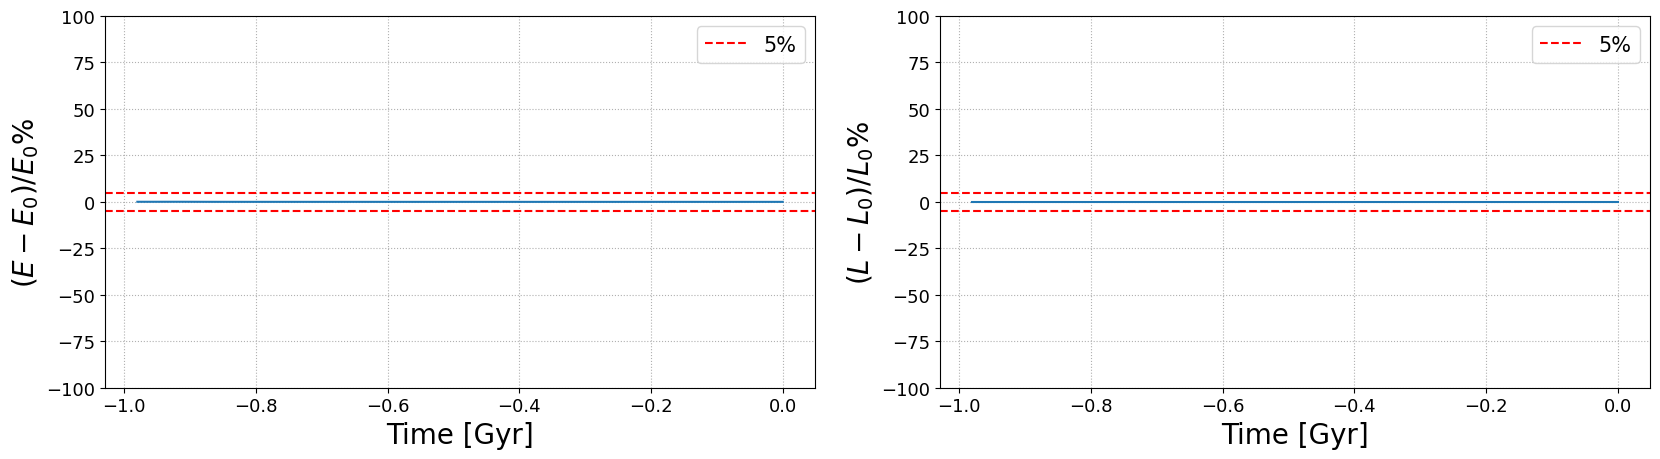

In [22]:
energy_angular_momentum_plot(backward_snapshots, code_units,)

# Diffrax (not working, not sure why)


In [23]:
from diffrax import diffeqsolve, ODETerm, SaveAt, Dopri5, Tsit5
from odisseo.dynamics import direct_acc_matrix
from odisseo.potentials import combined_external_acceleration_vmpa_switch

external_acc = combined_external_acceleration_vmpa_switch
acc_func = direct_acc_matrix



def vector_field(t, y, args):

    positions, velocities = y
    # Unpack the args
    mass  = args

    state = jnp.stack((positions, velocities), axis=1)


    d_positions = velocities  
    d_velocities = acc_func(state, mass, config, params) + external_acc(state, config, params)

    d_y = d_positions, d_velocities
    return d_y

term = ODETerm(vector_field)
solver = Dopri5()
t0 = 0.0
dt0 = jnp.array(0.01)
t1 = 0.01
y0 = initial_state[:, 0], initial_state[:, 1]
args = mass   

jitted_func = lambda : diffeqsolve(terms = term, solver=solver, t0 = t0, t1 = t1, dt0 = dt0, y0 = y0, args=args,)

# sol = diffeqsolve(terms = term, 
#                   solver = solver, 
#                   t0 = t0,
#                   t1 = t1,
#                   dt0 = dt0,
#                   y0 = y0,
#                   args=args,)

sol = jitted_func()

#if no stepsize controller is passed the time step is fixed
#if no Saveat si passed the solution is saved for y1
    


In [24]:
sol.ys

(Array([[[-0.18866947, -0.8378168 , -0.12171587],
         [ 0.00350901, -1.0781785 , -0.2245115 ],
         [ 0.18192135, -0.5406076 ,  0.04101389],
         ...,
         [ 0.11792776, -1.0246027 , -0.13894832],
         [ 0.09993419, -1.1855159 , -0.14904705],
         [ 0.07106569, -0.87373126, -0.16622916]]], dtype=float32),
 Array([[[ 4.4863144e+01, -1.5665913e-01,  5.7359567e+00],
         [ 4.0383766e+01, -8.3067513e-01,  5.8960676e+00],
         [ 3.9647068e+01,  9.7078533e+00, -5.8047667e+00],
         ...,
         [ 3.9828251e+01,  5.0234604e-01,  4.9064989e+00],
         [ 4.0348186e+01, -1.4454165e+00,  4.7187910e+00],
         [ 4.2445461e+01,  3.4002304e-02,  7.3979387e+00]]], dtype=float32))

In [25]:
jnp.stack((sol.ys[0][0], sol.ys[1][1]), axis=1).shape

(10000, 2, 3)

In [26]:
sol.ys[0].shape

(1, 10000, 3)

# DIFFRAX BACKEND

In [ ]:
from odisseo.option_classes import DIFFRAX_BACKEND, DOPRI5, TSIT5, SEMIIMPLICITEULER

In [37]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          integrator = DIFFRAX_BACKEND,
                          diffrax_solver = DOPRI5,
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
ra = 200*u.kpc.to(code_units.code_length)
e = 0.9
rp = (1-e)/(1+e) * ra

pos_com = sample_position_on_sphere(key=key,
                                r_p = rp,
                                num_samples=1,)
z = pos_com[0, 2]
inclination = jnp.pi/2 - jnp.acos(z/rp)

mass1 = mass_enclosed_MN(rp, z) + mass_enclosed_NFW(rp)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel_com = inclined_circular_velocity(pos_com, bulk_velocity_modulus, inclination)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

In [38]:
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

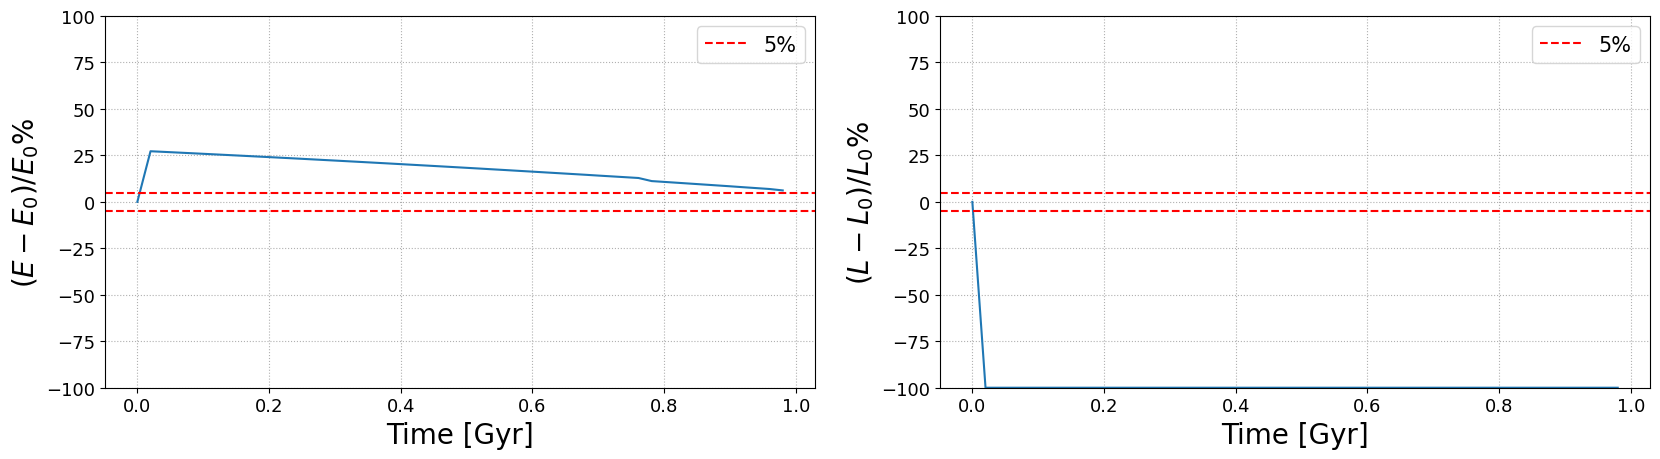

In [40]:
energy_angular_momentum_plot(snapshots, code_units,)